<a href="https://colab.research.google.com/github/DiegoeFarfan-SLA/labo2025v/blob/main/Analisis___Resultados__Grupo_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# 0. MONTAR GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ============================================================
# 1. IMPORTAR LIBRERÍAS
# ============================================================
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

In [3]:
# ============================================================
# 2. CARGAR ARCHIVO DESDE DRIVE
#    Ajusta la extensión si hiciera falta (.csv / .CSV)
# ============================================================
ruta = "/content/drive/MyDrive/labo1/Exp 11 Grupo B/Resul_11_B.csv"
df = pd.read_csv(ruta)

In [4]:
# ============================================================
# 3. NORMALIZACIÓN DE COLUMNAS NUMÉRICAS
# ============================================================
def norm(x):
    """Limpia números con comas, puntos, $, etc."""
    if isinstance(x, str):
        x = x.replace("$", "").replace(".", "").replace(",", ".")
    try:
        return float(x)
    except:
        return np.nan

df["AUC_mean"] = df["AUC_mean"].apply(norm)
df["AUC_sd"] = df["AUC_sd"].apply(norm)
df["Tiempo_mean"] = df["Tiempo (s)_mean"].apply(norm)
df["Tiempo_sd"] = df["Tiempo (s)_sd"].apply(norm)
df["N_train"] = df["N_train"].apply(norm)
df["Ganancia"] = df["Ganancia_suavizada_max"].apply(norm)
df["undersampling"] = df["Undersampling (training_pct)"].apply(norm)
df["semilla"] = df["Semilla"].astype(int)

In [5]:
# ============================================================
# 4. DEFINIR CONTROL = 1.0
# ============================================================
control = 1.0

df_control = df[df["undersampling"] == control].sort_values("semilla")

niveles = sorted(df["undersampling"].dropna().unique())
niveles_sin_control = [n for n in niveles if n != control]

In [6]:
# ============================================================
# 5. FUNCIÓN GENERAL DE WILCOXON PAREADO
# ============================================================
def wilcoxon_vs_control(df, variable, nivel):
    """
    Compara con Wilcoxon pareado (por semilla) la métrica "variable"
    entre undersampling = control y undersampling = nivel.
    """
    df_c = df[(df["undersampling"] == control)][["semilla", variable]].dropna()
    df_t = df[(df["undersampling"] == nivel)][["semilla", variable]].dropna()

    df_c = df_c.sort_values("semilla")
    df_t = df_t.sort_values("semilla")

    semillas_comunes = np.intersect1d(df_c["semilla"], df_t["semilla"])

    g1 = df_c[df_c["semilla"].isin(semillas_comunes)][variable].values
    g2 = df_t[df_t["semilla"].isin(semillas_comunes)][variable].values

    if len(g1) == 0:
        return {
            "undersampling": nivel,
            "pares": 0,
            "p_value": np.nan,
            "media_control": np.nan,
            "media_nivel": np.nan,
            "delta": np.nan,
            "delta_pct": np.nan
        }

    stat, p = wilcoxon(g1, g2)

    media_c = np.mean(g1)
    media_t = np.mean(g2)
    delta = media_t - media_c
    delta_pct = (delta / media_c) * 100 if media_c != 0 else np.nan

    return {
        "undersampling": nivel,
        "pares": len(g1),
        "p_value": p,
        "media_control": media_c,
        "media_nivel": media_t,
        "delta": delta,
        "delta_pct": delta_pct
    }

In [7]:
# ============================================================
# 6. APLICAR WILCOXON PARA GANANCIA Y PARA AUC
# ============================================================
resultados_ganancia = [wilcoxon_vs_control(df, "Ganancia", nivel)
                       for nivel in niveles_sin_control]
resultados_auc = [wilcoxon_vs_control(df, "AUC_mean", nivel)
                  for nivel in niveles_sin_control]

df_gan = pd.DataFrame(resultados_ganancia).sort_values("undersampling")
df_auc = pd.DataFrame(resultados_auc).sort_values("undersampling")

df_gan["significativo_0.05"] = df_gan["p_value"] < 0.05
df_auc["significativo_0.05"] = df_auc["p_value"] < 0.05

In [8]:
# ============================================================
# 7. GUARDAR RESULTADOS EN CSV (EN /content)
# ============================================================
df_gan.to_csv("/content/wilcoxon_ganancia_vs_control.csv", index=False)
df_auc.to_csv("/content/wilcoxon_auc_vs_control.csv", index=False)

print("Archivos generados en /content:")
print("-> wilcoxon_ganancia_vs_control.csv")
print("-> wilcoxon_auc_vs_control.csv")


Archivos generados en /content:
-> wilcoxon_ganancia_vs_control.csv
-> wilcoxon_auc_vs_control.csv


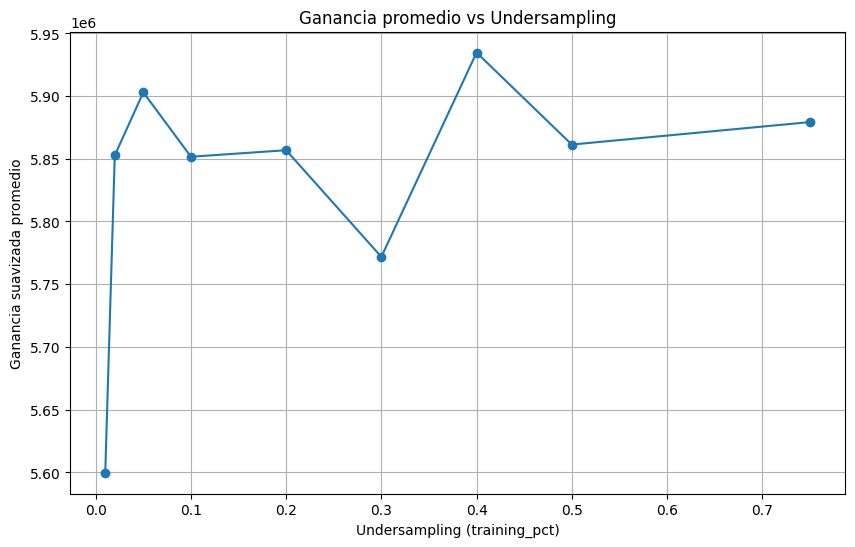

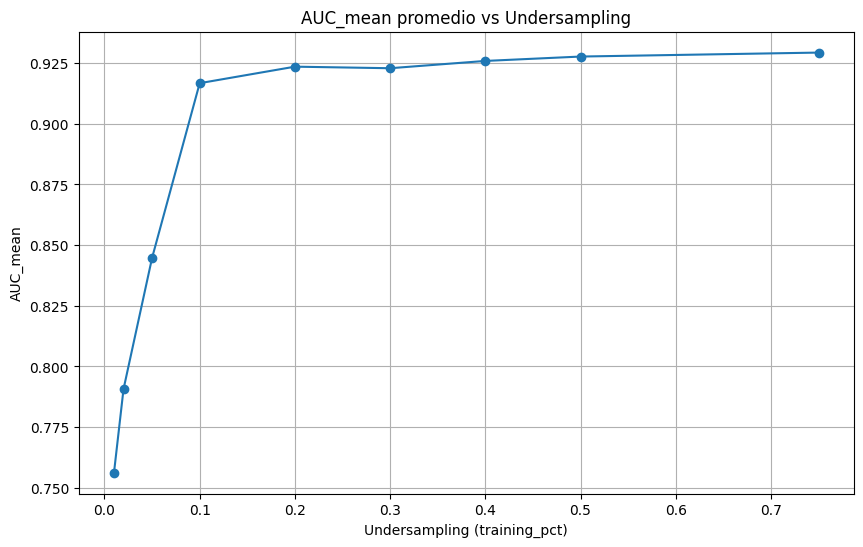

In [9]:
# ============================================================
# 8. GRÁFICOS PARA INFORME
# ============================================================
plt.figure(figsize=(10,6))
plt.plot(df_gan["undersampling"], df_gan["media_nivel"], marker="o")
plt.title("Ganancia promedio vs Undersampling")
plt.xlabel("Undersampling (training_pct)")
plt.ylabel("Ganancia suavizada promedio")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(df_auc["undersampling"], df_auc["media_nivel"], marker="o")
plt.title("AUC_mean promedio vs Undersampling")
plt.xlabel("Undersampling (training_pct)")
plt.ylabel("AUC_mean")
plt.grid(True)
plt.show()

In [10]:
# ============================================================
# 9. TEXTO INTERPRETATIVO PARA INFORME
# ============================================================
def interpretar(df, variable):
    texto = f"\n\n### Interpretación para {variable}\n"
    texto += "Comparando cada nivel de undersampling contra el modelo control (training_pct = 1.0):\n\n"
    for _, row in df.iterrows():
        nivel = row["undersampling"]
        p = row["p_value"]
        delta_pct = row["delta_pct"]
        signif = row["significativo_0.05"]
        texto += f"- Undersampling {nivel}: p-value={p:.4f}, cambio relativo={delta_pct:.2f}% "
        texto += "(**significativo**)\n" if signif else "(no significativo)\n"
    return texto

print(interpretar(df_gan, "Ganancia"))
print(interpretar(df_auc, "AUC_mean"))



### Interpretación para Ganancia
Comparando cada nivel de undersampling contra el modelo control (training_pct = 1.0):

- Undersampling 0.01: p-value=1.0000, cambio relativo=-0.55% (no significativo)
- Undersampling 0.02: p-value=0.5000, cambio relativo=3.94% (no significativo)
- Undersampling 0.05: p-value=0.5000, cambio relativo=4.83% (no significativo)
- Undersampling 0.1: p-value=0.5000, cambio relativo=3.92% (no significativo)
- Undersampling 0.2: p-value=0.2500, cambio relativo=4.01% (no significativo)
- Undersampling 0.3: p-value=1.0000, cambio relativo=2.50% (no significativo)
- Undersampling 0.4: p-value=0.2500, cambio relativo=5.39% (no significativo)
- Undersampling 0.5: p-value=0.7500, cambio relativo=4.09% (no significativo)
- Undersampling 0.75: p-value=0.7500, cambio relativo=4.41% (no significativo)



### Interpretación para AUC_mean
Comparando cada nivel de undersampling contra el modelo control (training_pct = 1.0):

- Undersampling 0.01: p-value=0.2500, cambio rel

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Renombrar columnas solo una vez ---
df = df.rename(columns={
    'Undersampling (training_pct)': 'training_pct',
    'Tiempo (s)_mean': 'tiempo_mean_s',
    'Tiempo (s)_sd': 'tiempo_sd_s'
})

print(df.columns)

# --- Función robusta para parsear números con miles y comas/puntos mezclados ---
def limpiar_columna_num(col):
    s = df[col].astype(str)

    def parse_val(v):
        v = v.strip()
        if v == '' or v.lower() == 'nan':
            return float('nan')

        # dejar solo dígitos, comas y puntos
        v = ''.join(ch for ch in v if ch.isdigit() or ch in ',.')

        # 1) si hay más de una coma, la última es el decimal, el resto son miles
        if v.count(',') > 1:
            parte_entera, parte_dec = v.rsplit(',', 1)
            parte_entera = ''.join(ch for ch in parte_entera if ch.isdigit())
            v = parte_entera + '.' + parte_dec
        else:
            v = v.replace(',', '.')

        # 2) si aún quedan varios puntos, dejamos solo el último como decimal
        if v.count('.') > 1:
            parte_entera, parte_dec = v.rsplit('.', 1)
            parte_entera = ''.join(ch for ch in parte_entera if ch.isdigit())
            v = parte_entera + '.' + parte_dec

        return float(v)

    return s.apply(parse_val)

# Limpiamos las columnas relevantes
for c in ['AUC_mean', 'AUC_sd', 'tiempo_mean_s', 'tiempo_sd_s']:
    df[c] = limpiar_columna_num(c)

# N_train a entero (sacando posibles separadores de miles)
df['N_train'] = (
    df['N_train']
      .astype(str)
      .str.replace(r'[^0-9]', '', regex=True)
      .astype(int)
)

df.dtypes


Index(['Semilla', 'training_pct', 'AUC_mean', 'AUC_sd', 'tiempo_mean_s',
       'tiempo_sd_s', 'N_train', 'Ganancia_suavizada_max', 'Tiempo_mean',
       'Tiempo_sd', 'Ganancia', 'undersampling', 'semilla'],
      dtype='object')


,0
Semilla,int64
training_pct,object
AUC_mean,float64
AUC_sd,float64
tiempo_mean_s,float64
tiempo_sd_s,float64
N_train,int64
Ganancia_suavizada_max,object
Tiempo_mean,float64
Tiempo_sd,float64


  training_pct  Tiempo_mean_global  Tiempo_sd_global  N_train_mean
0         0,01           61.528000         48.372221  3.459333e+04
1         0,02           44.768333         58.896562  5.344667e+04
2         0,05          132.839333         98.011268  1.100233e+05
3          0,1          166.408333        228.451075  2.046233e+05
4          0,2          386.856667        278.645777  3.943067e+05
5          0,3          706.225333         91.560722  5.832100e+05
6          0,4          427.211333        554.332738  7.731100e+05
7          0,5         1032.393000        289.131118  9.623167e+05
8         0,75          205.735000         25.455795  1.436777e+06
9            1          204.715000         48.983086  1.910350e+06


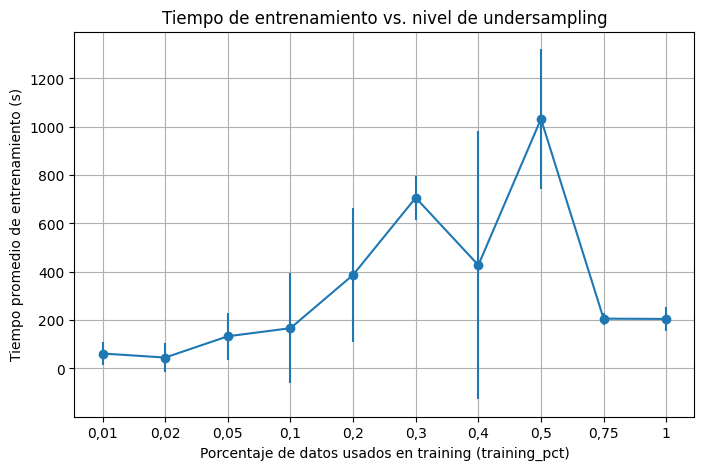

In [20]:
# Resumen del tiempo por nivel de undersampling
resumen_tiempo = (
    df
    .groupby('training_pct', as_index=False)
    .agg(
        Tiempo_mean_global=('tiempo_mean_s', 'mean'),
        Tiempo_sd_global=('tiempo_mean_s', 'std'),
        N_train_mean=('N_train', 'mean')
    )
    .sort_values('training_pct')
)

print(resumen_tiempo)

# Gráfico: tiempo promedio vs nivel de undersampling
plt.figure(figsize=(8,5))
plt.errorbar(
    resumen_tiempo['training_pct'],
    resumen_tiempo['Tiempo_mean_global'],
    yerr=resumen_tiempo['Tiempo_sd_global'],
    marker='o',
    linestyle='-'
)
plt.xlabel('Porcentaje de datos usados en training (training_pct)')
plt.ylabel('Tiempo promedio de entrenamiento (s)')
plt.title('Tiempo de entrenamiento vs. nivel de undersampling')
plt.grid(True)
plt.show()
